In [34]:
from helper import*
import params as cfg
import sys
sys.path.insert(1, '/Users/joshuaighalo/Documents/GitHub/eegDementia')

In [35]:
# group-task-time
M = [['m11_1.zip'],['m12_1.zip']]
localDir = "/Users/joshuaighalo/Downloads/Mind_Monitor/"
destDir = "/Users/joshuaighalo/Downloads/Mind_Monitor/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'

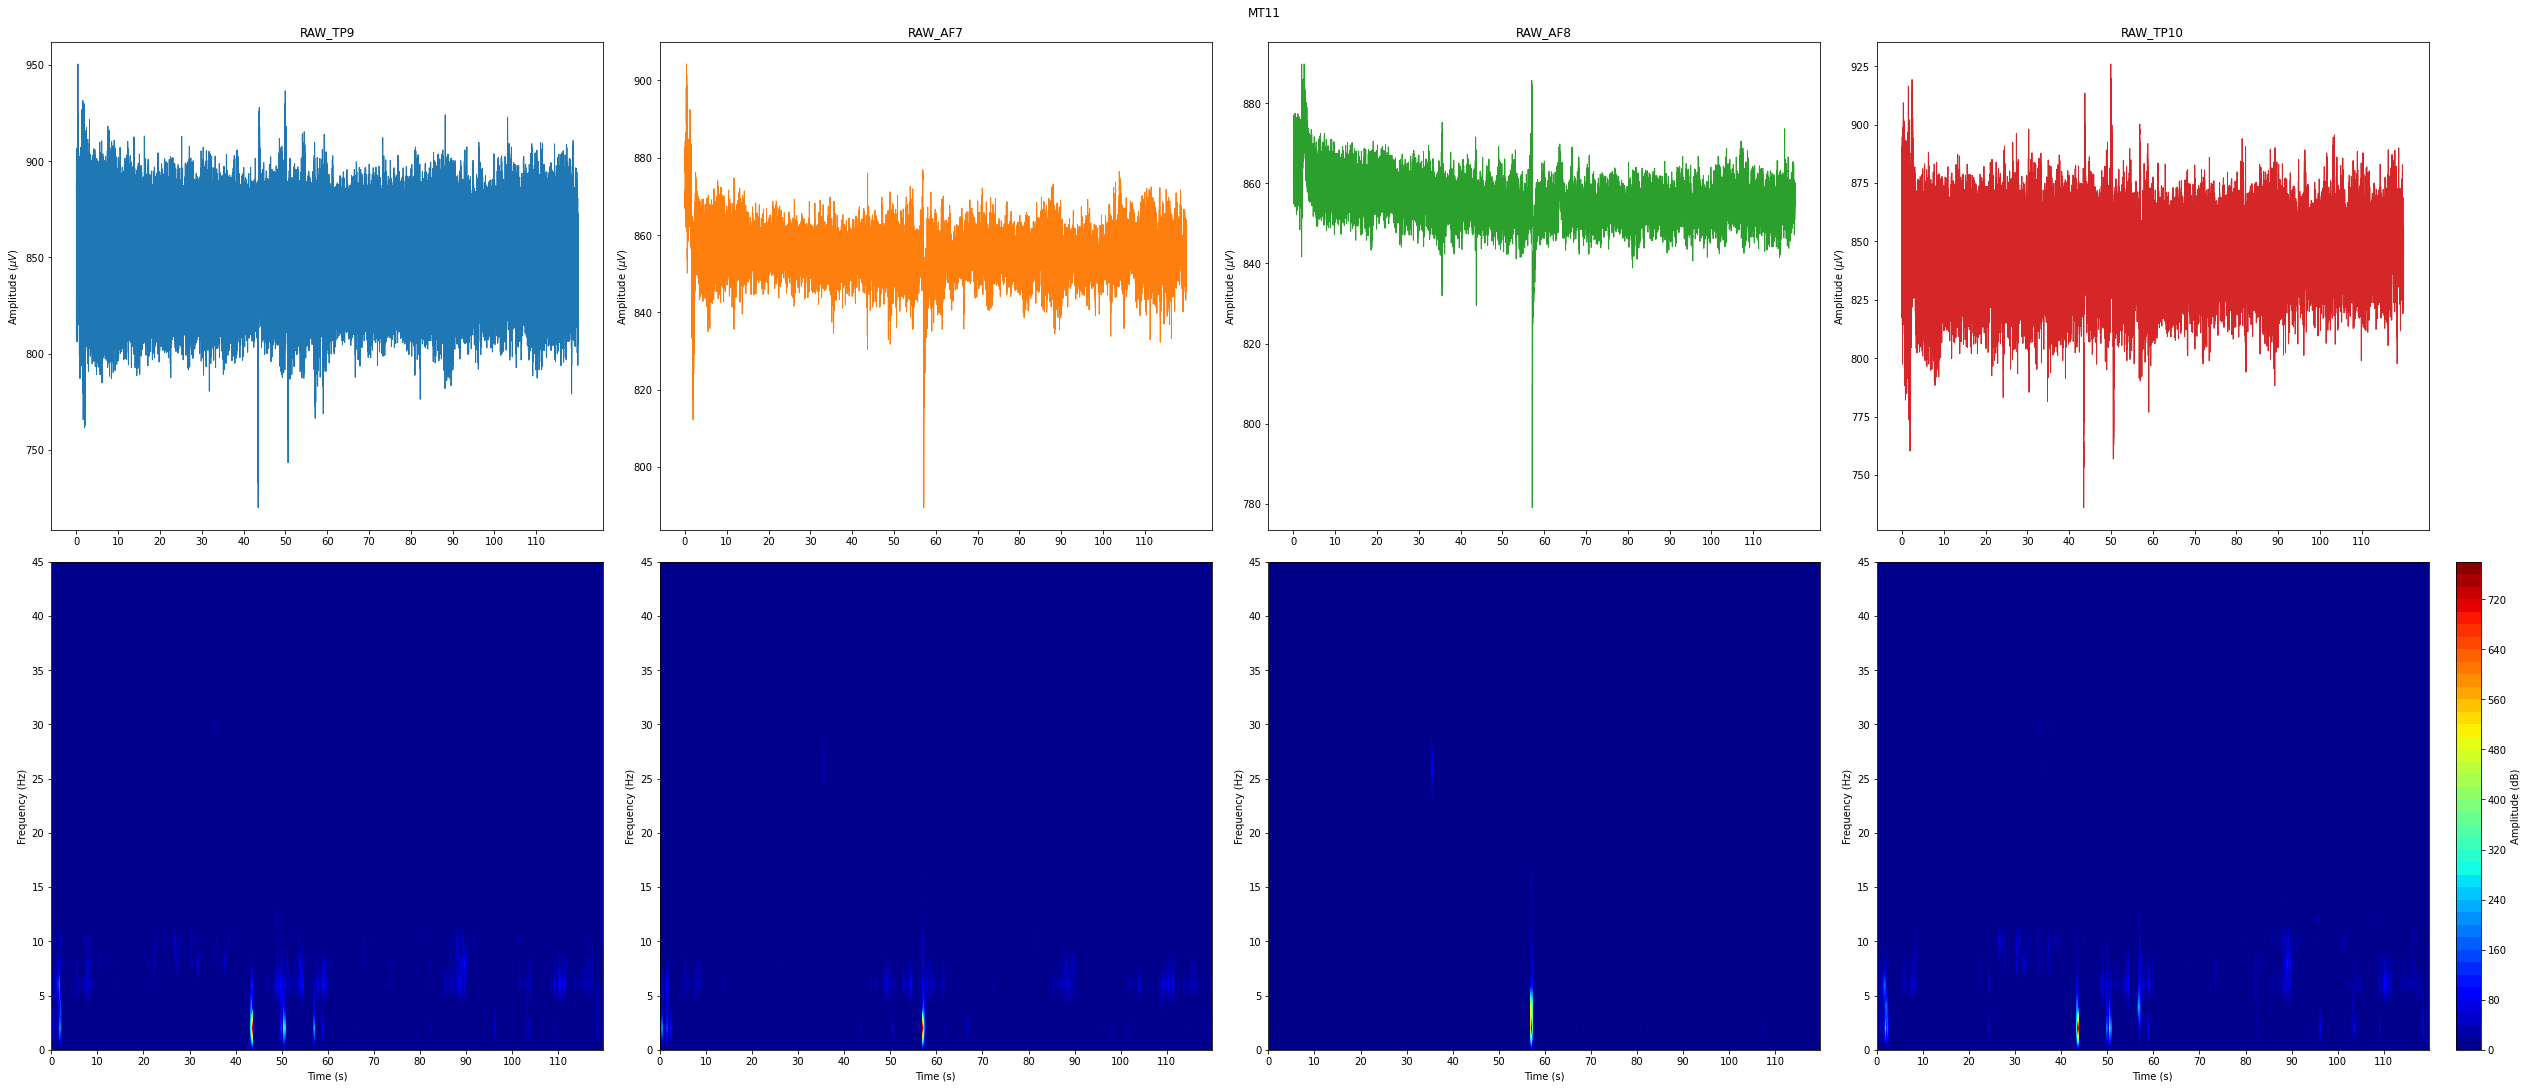

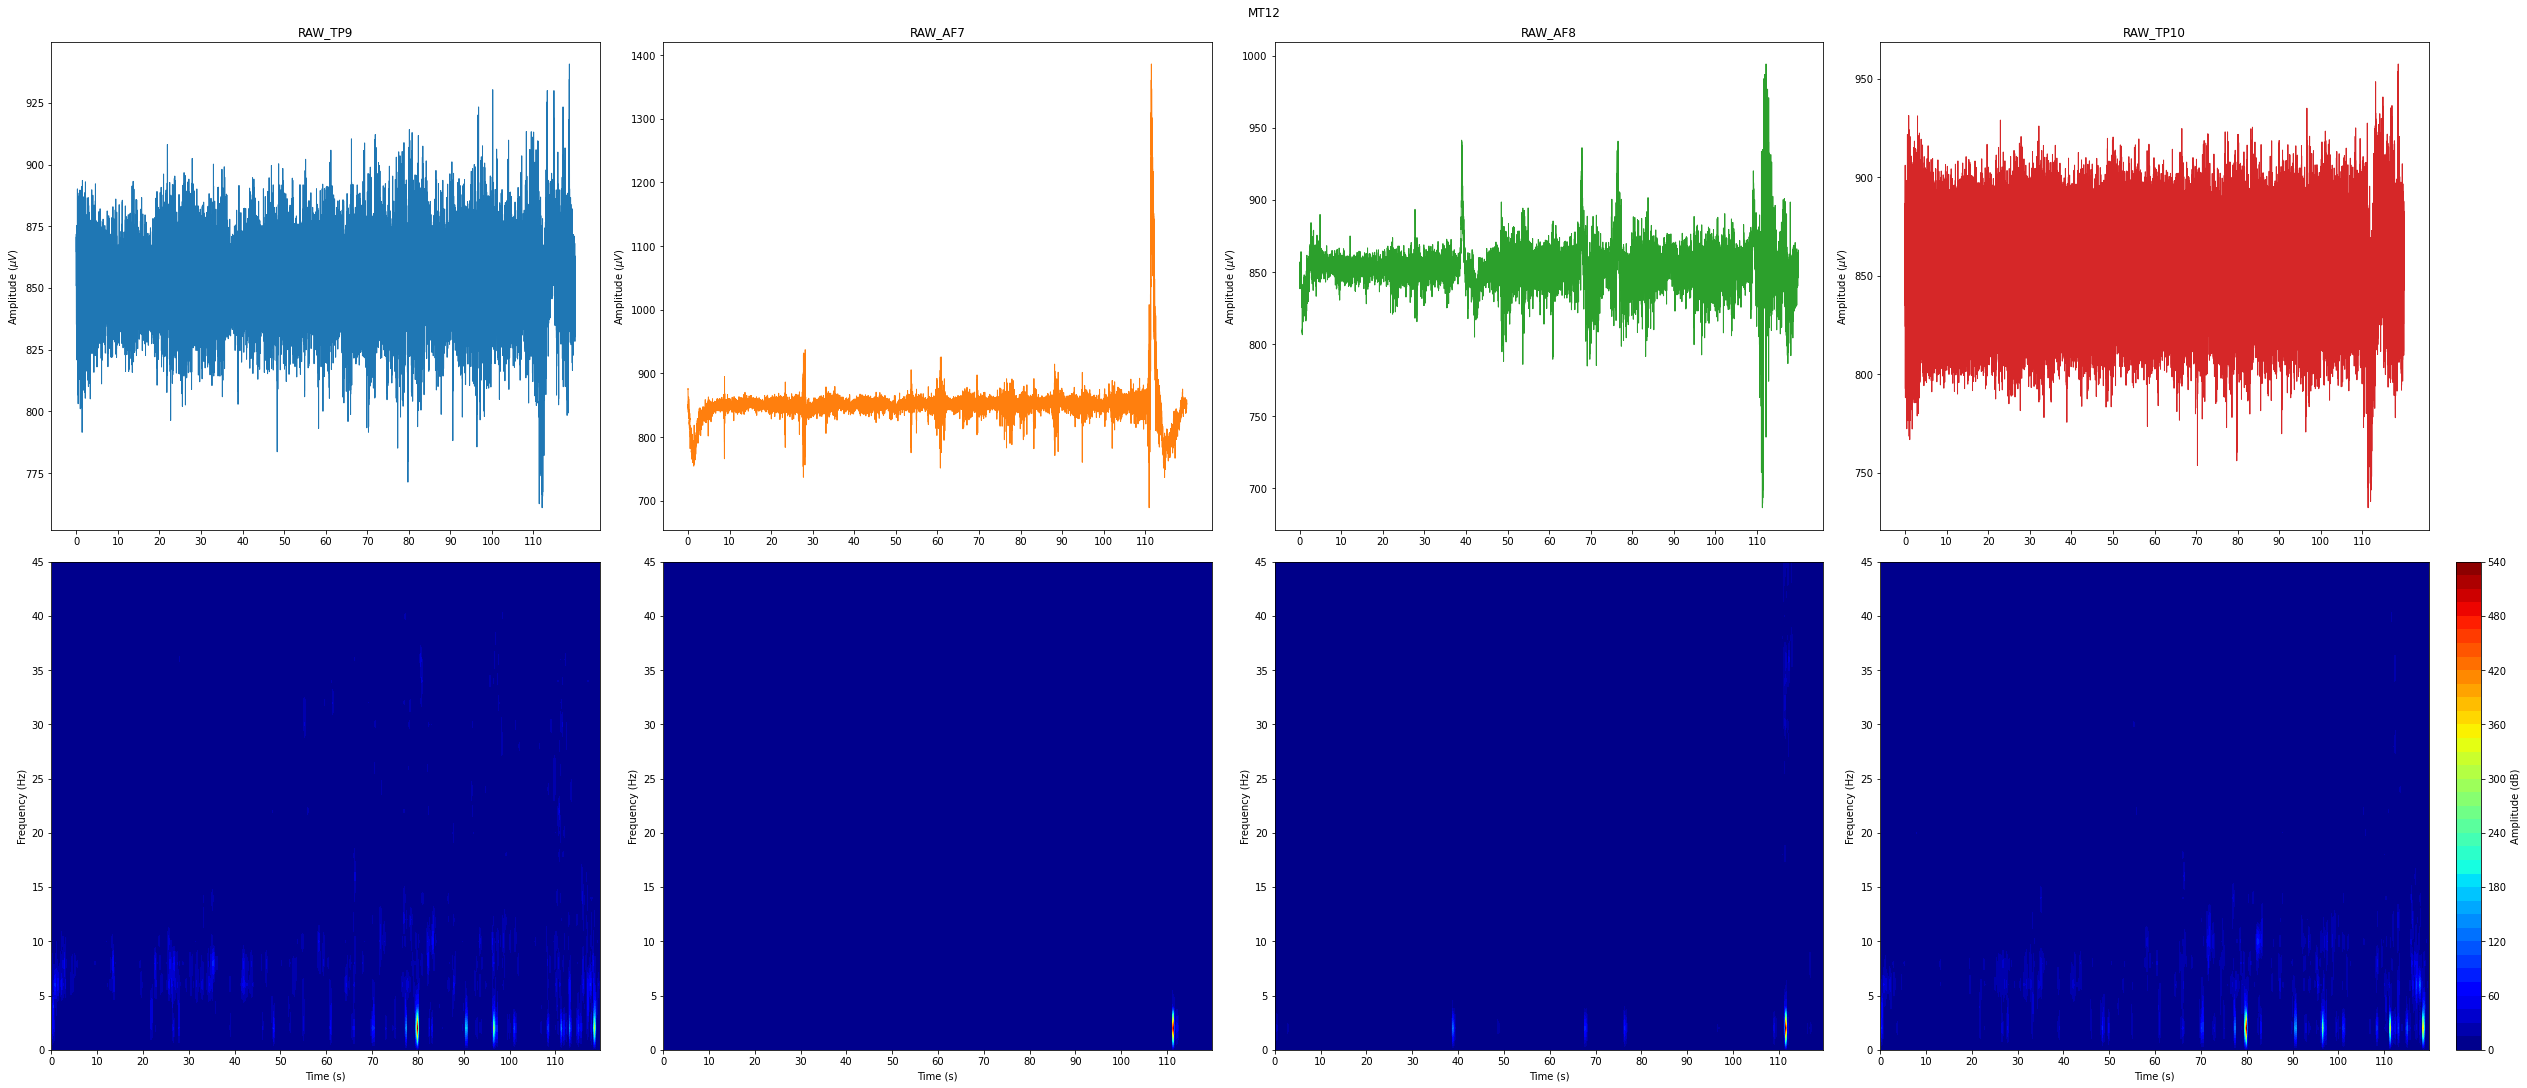

In [36]:
MT11 = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT11 = MT11.reshape(MT11.shape[1],MT11.shape[2])
MT12 = zipExtract(M[1],localDir,destDir,"M12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT12 = MT12.reshape(MT12.shape[1],MT12.shape[2])
time_s = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[2][0]
time_s = time_s.reshape(len(time_s),1)
time_s = time_s[0:int(cfg.collection_time*cfg.fs)]

plots(data=MT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
          title='MT11',tickRange=[0,120],timeFrequencyDomainPlots=True)
plots(data=MT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='MT12',tickRange=[0,120],timeFrequencyDomainPlots=True)

<b>EMD<b>

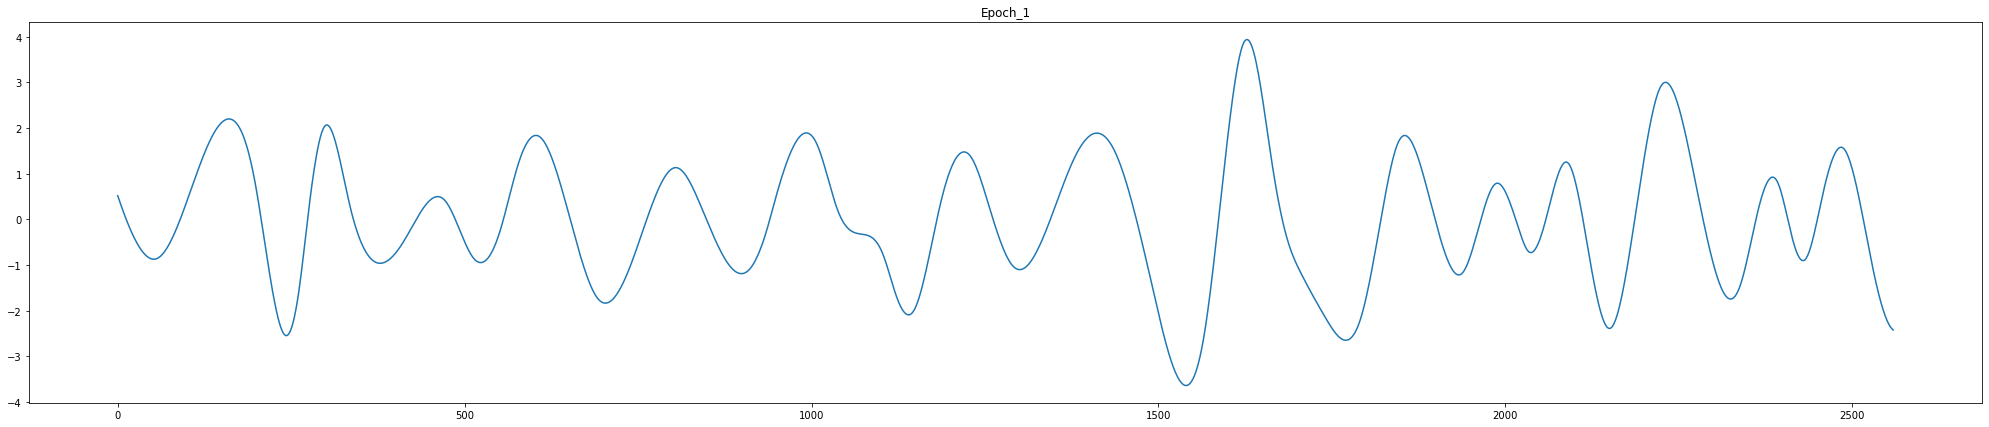

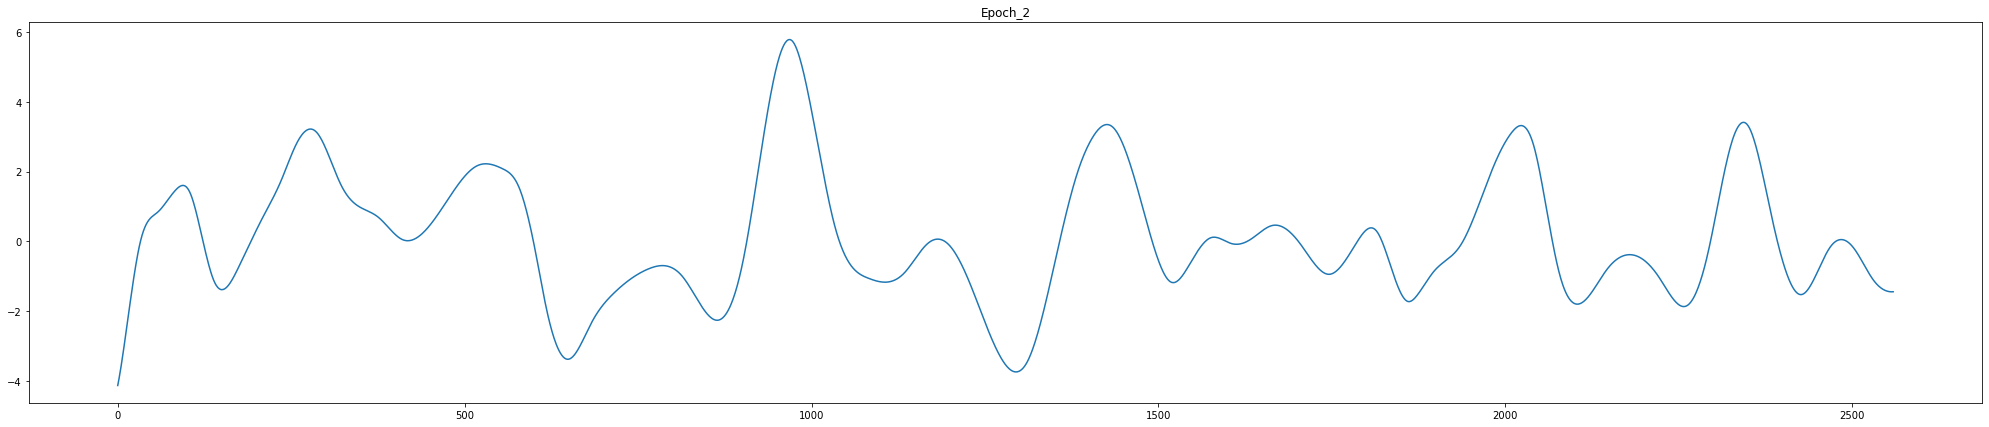

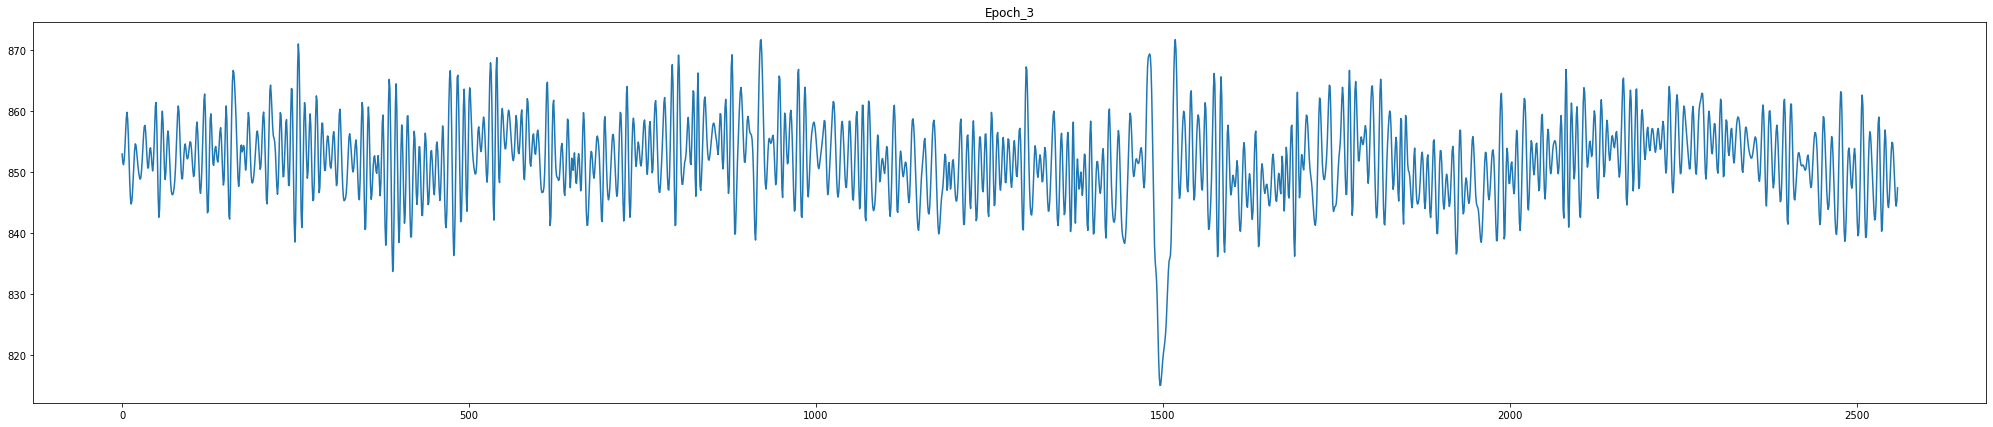

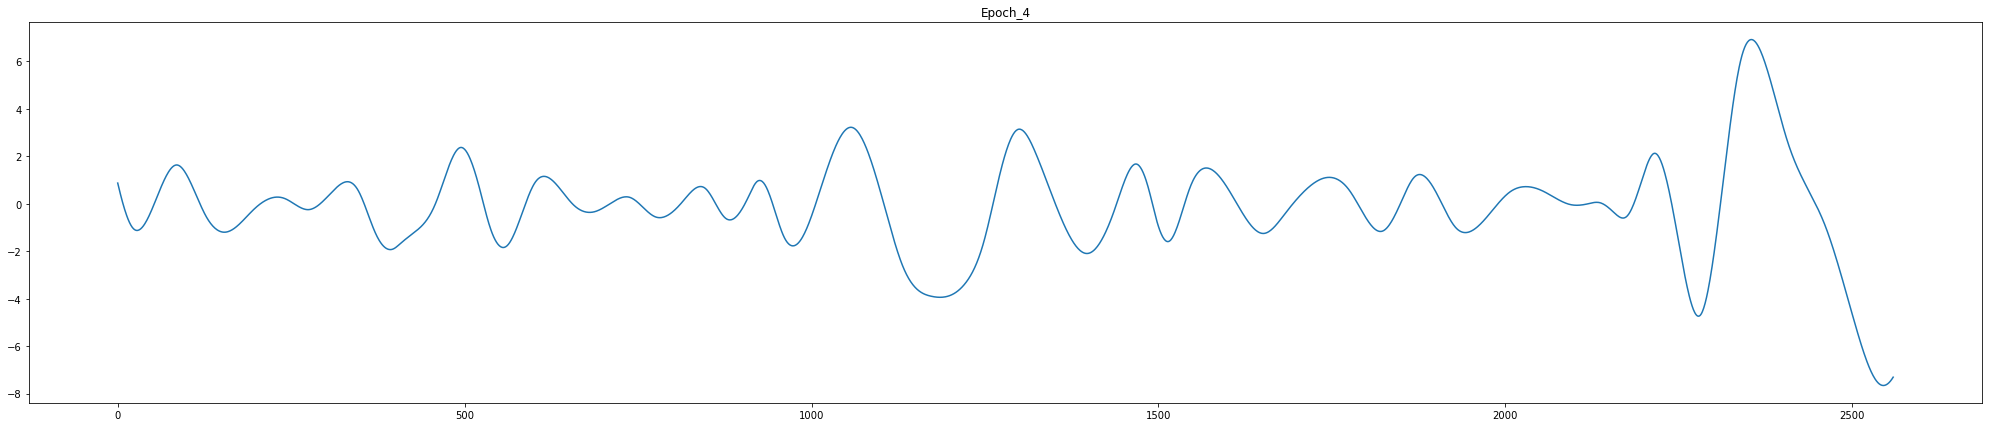

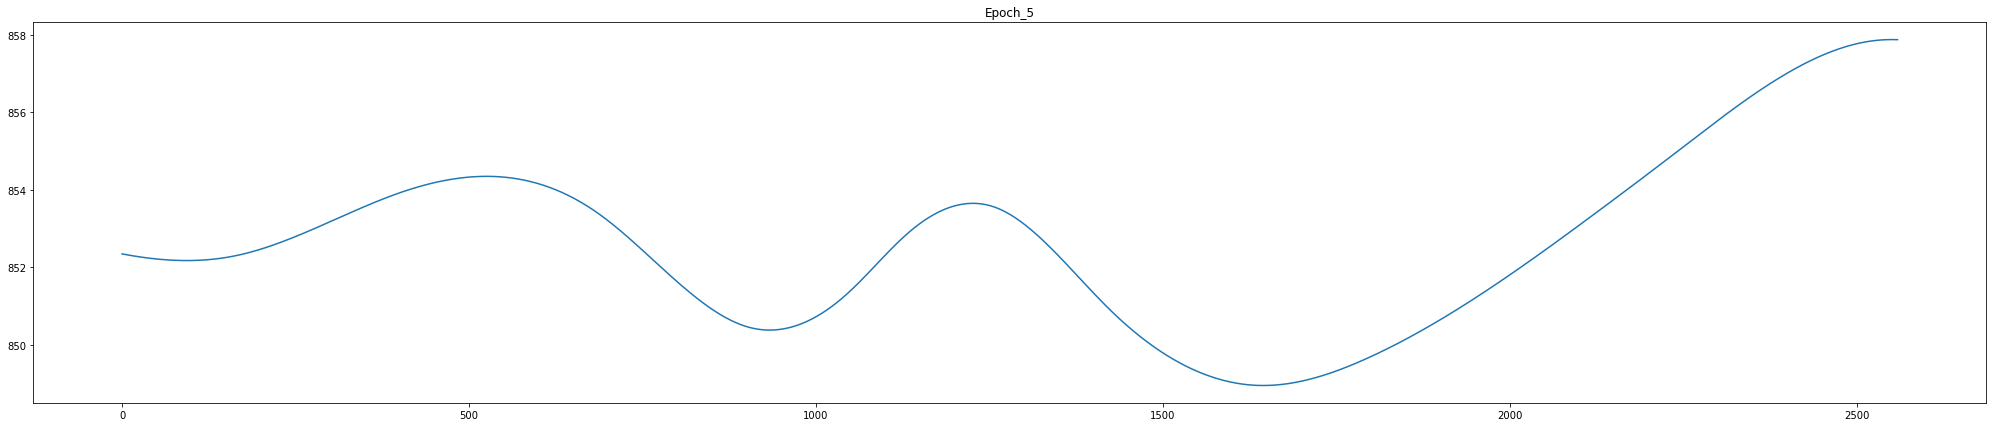

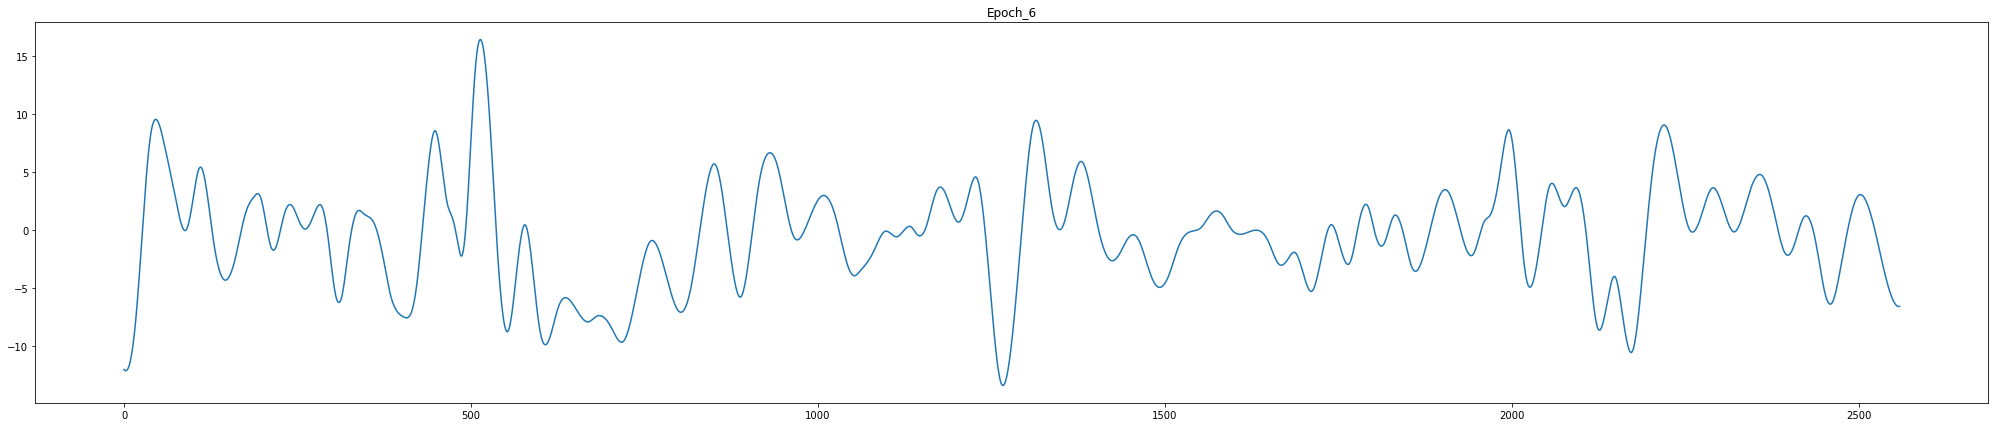

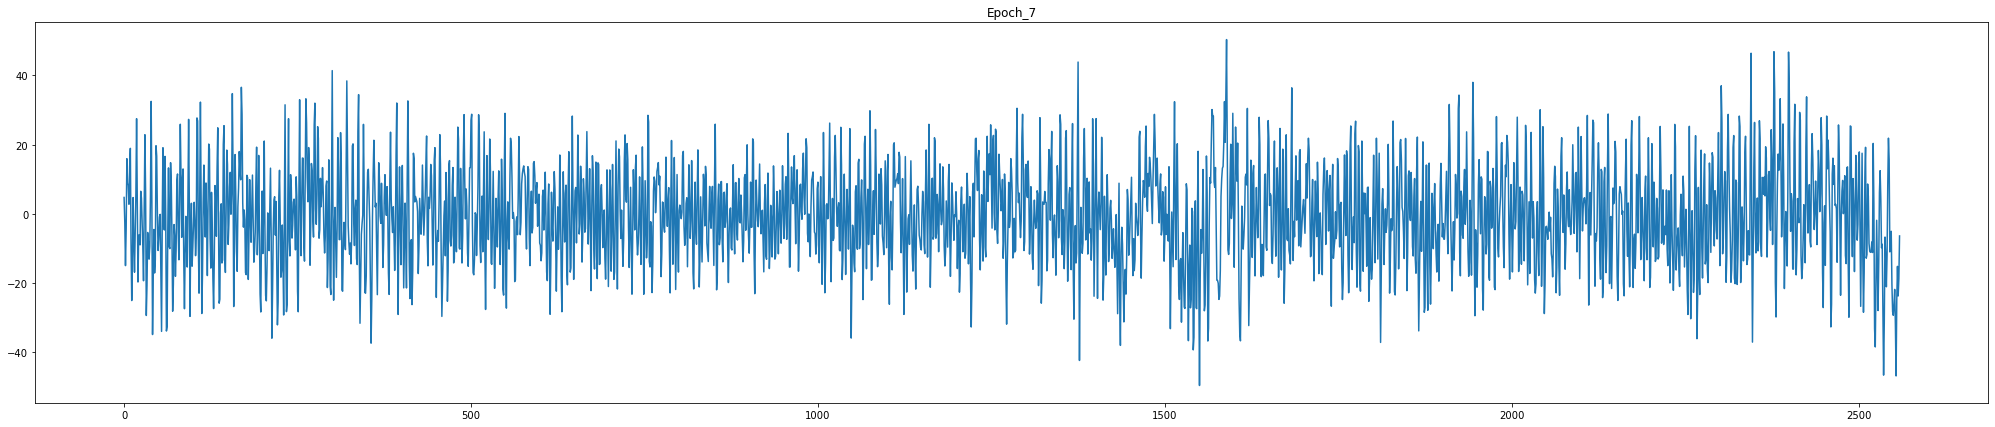

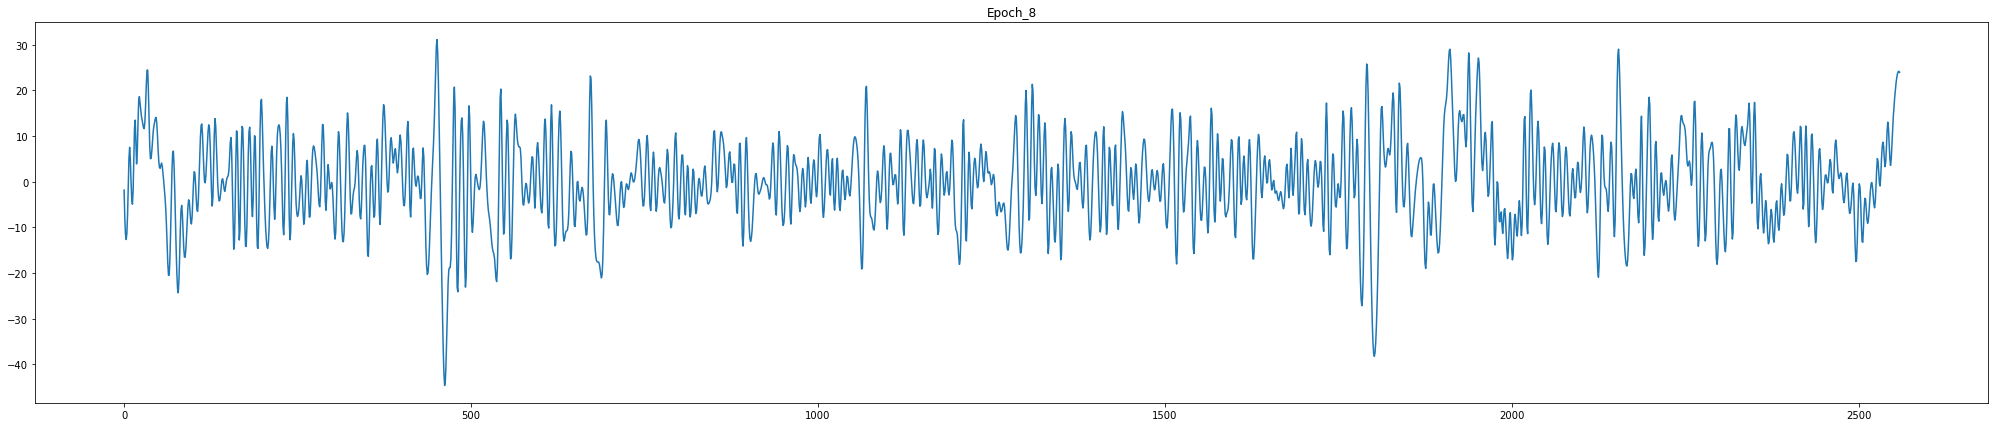

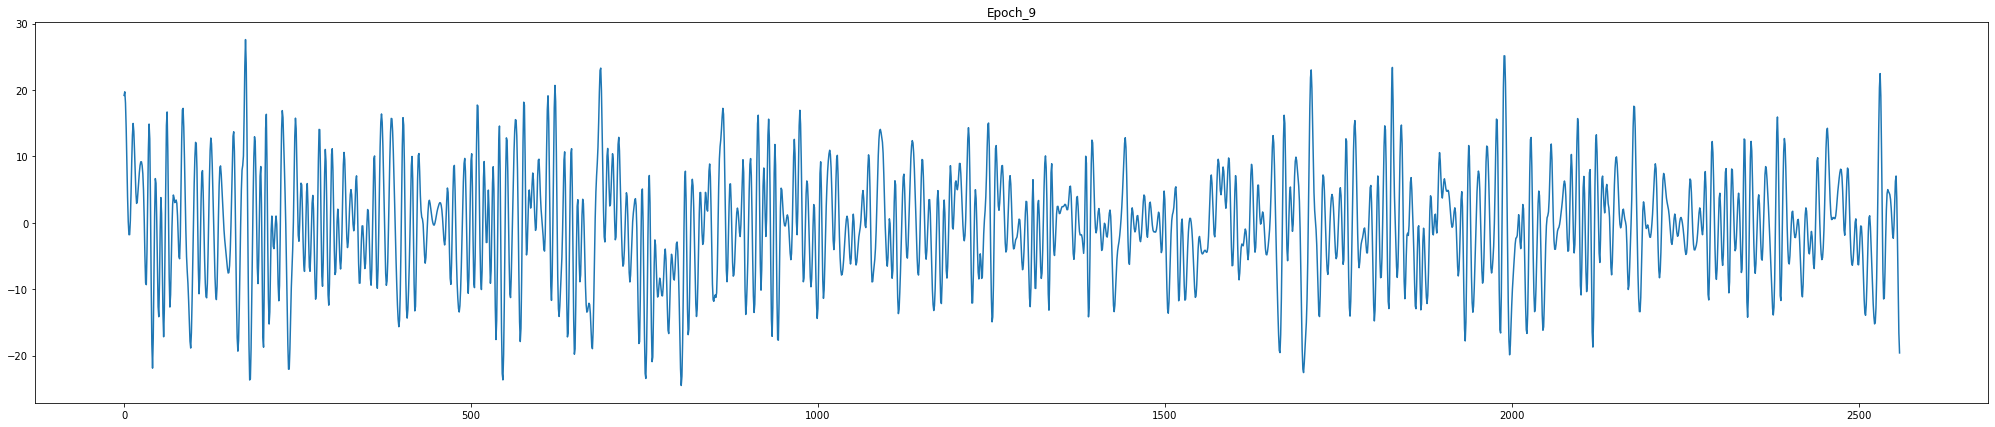

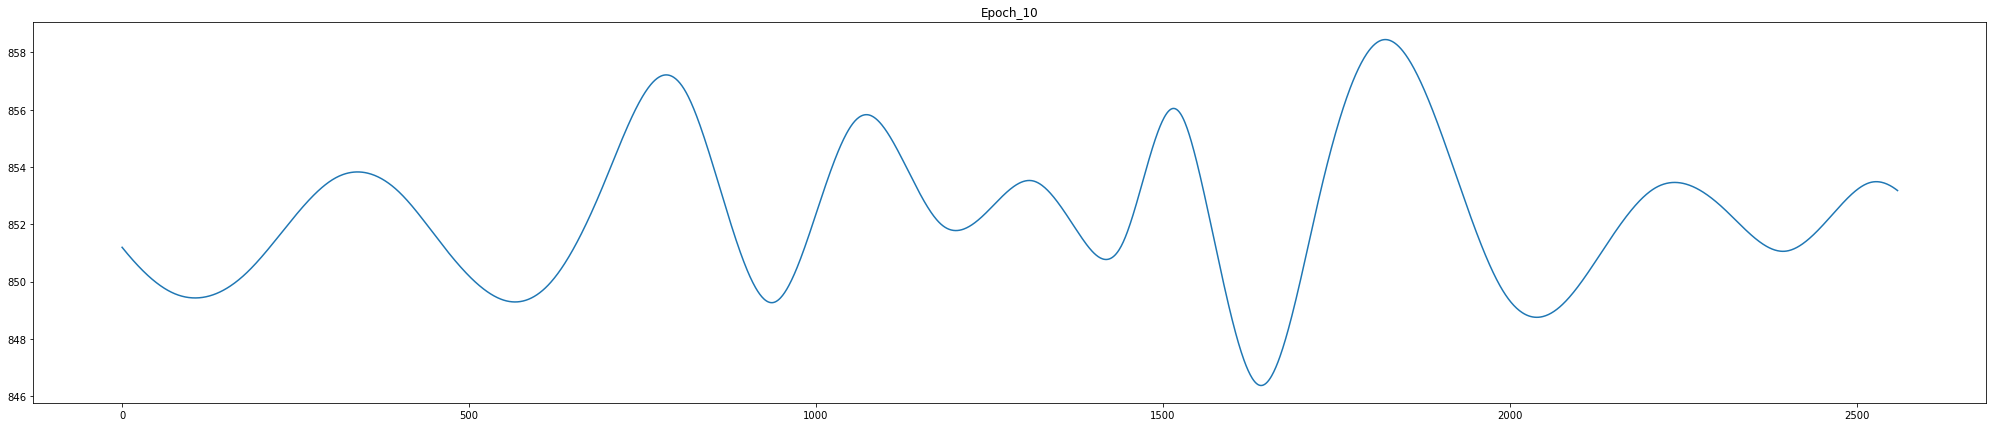

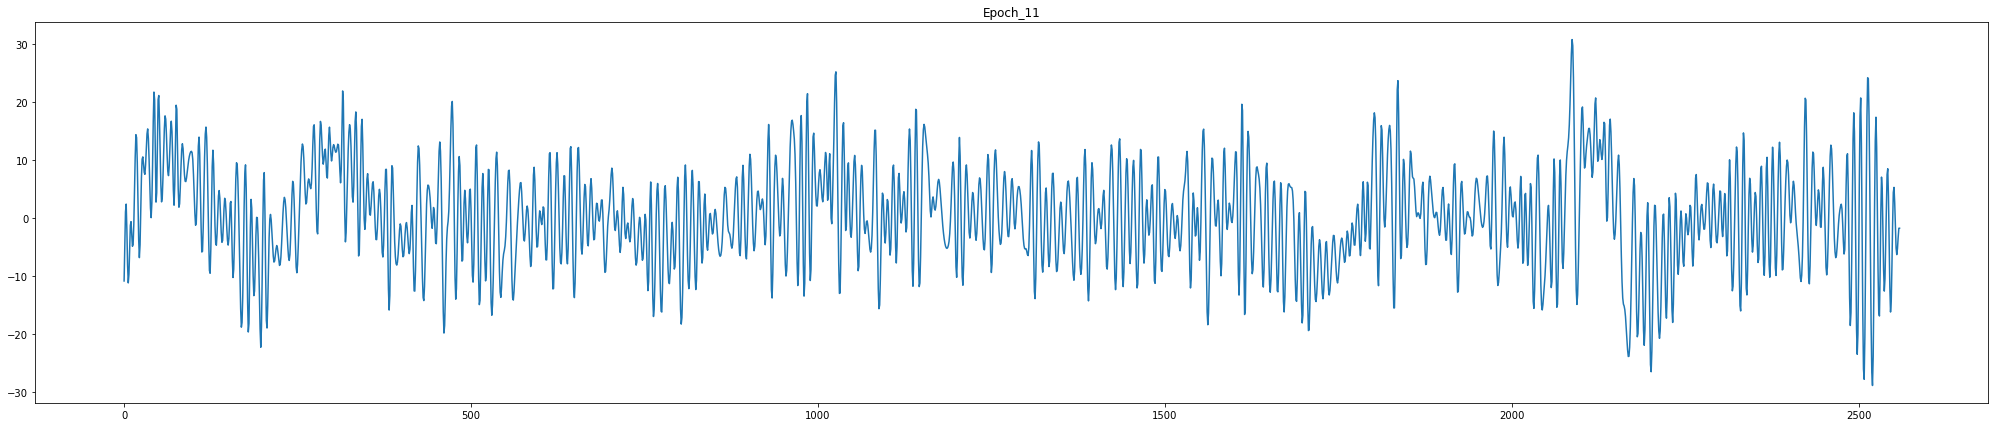

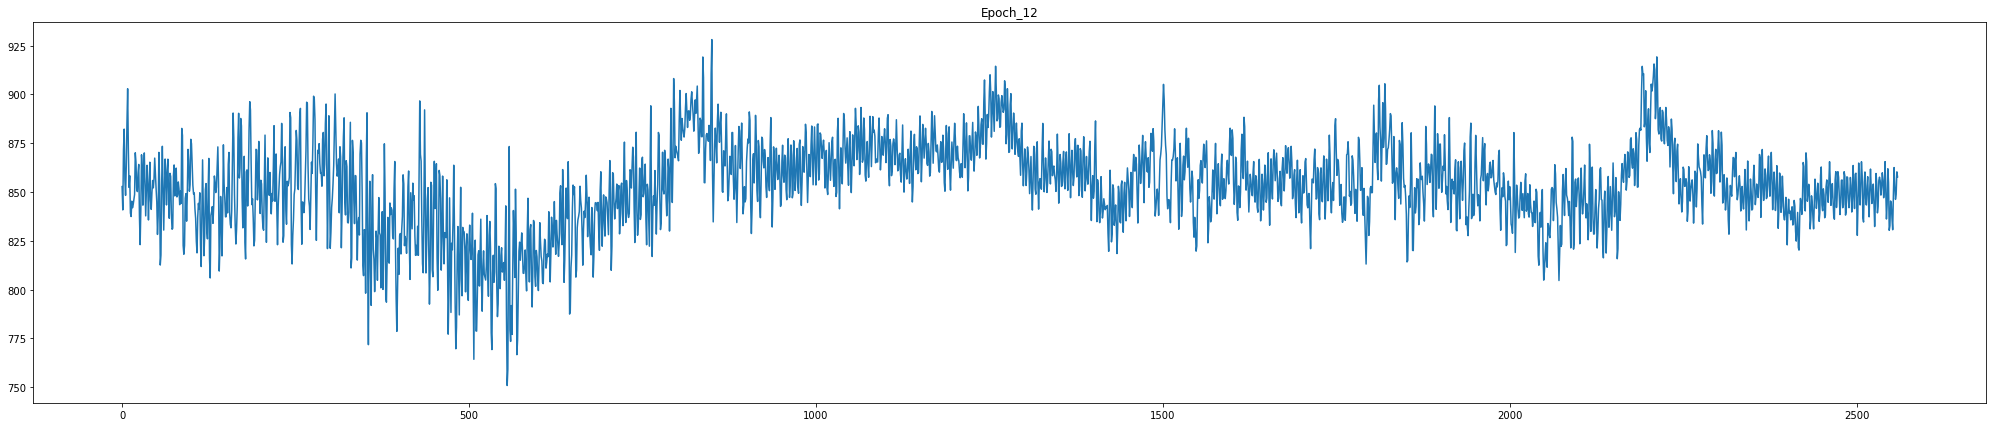

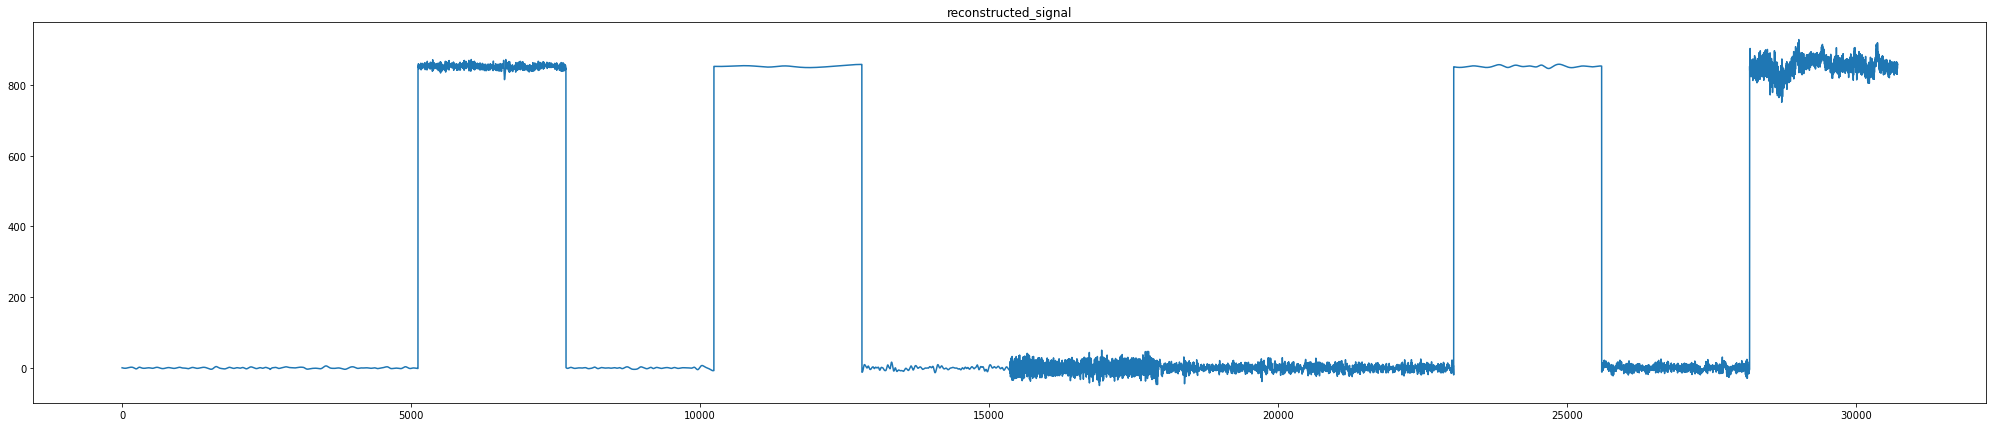

"\nplt.figure(figsize=(35,7))\nplt.plot(winsTP9[0])\nplt.title('original Signal')\nplt.show()\nfor i in range(imf_chans.shape[1]):\n    plt.figure(figsize=(35,7))\n    plt.plot(imf_chans[:,i])\n    plt.title('IMF_%s' % (i+1))\n    plt.show()\n"

In [37]:
data = MT12
windows = slidingWindow(data,time_s,10,10)
winsTP9 = windows[0]
winsAF7 = windows[1]
winsTemplate = winsAF7.T

def windowIMF(input):
    imfs = []
    for i in range(input.shape[0]):
        imfs.append(np.hstack(((emd.sift.sift(input[i])),np.full(((emd.sift.sift(input[i])).shape[0],15-(emd.sift.sift(input[i])).shape[1]),np.nan))))
    imfs = np.array(imfs)
    return imfs

imfswinsTP9 = windowIMF(winsTP9)

def corrcomparison(imfs,template):
    corr = []
    for i in range(imfs.shape[1]):
        corr.append(np.corrcoef(imfs[:,i],template)[0,1])
    corr = np.array(corr)
    return corr
# loop through imfswinsTP9 and winsTemplate
corr = []
for i in range(imfswinsTP9.shape[0]):
    corr.append(corrcomparison(imfswinsTP9[i],winsTemplate[:,i]))
corr = np.array(corr)   # window x imfs
# for every row, extract the column index of values greater than 0
idx_poscorr = []
for i in range(corr.shape[0]):
    idx_poscorr.append(np.where(corr[i]>0)[0])
idx_poscorr = np.array(idx_poscorr)

# use idx_poscorr to delete the corresponding columns in imfswinsTP9
def delcolumns(data,indices):
    output = []
    for i in range(data.shape[0]):
        output.append(np.hstack(((np.delete(data[i],indices[i],axis=1)),np.full(((np.delete(data[i],indices[i],axis=1)).shape[0],30-(np.delete(data[i],indices[i],axis=1)).shape[1]),np.nan))))
    output = np.array(output)
    return output

cleanIMFS = delcolumns(imfswinsTP9,idx_poscorr)
reconstructed_wins = np.nansum(cleanIMFS,axis=2)
reconstructed_signal = reconstructed_wins.reshape(reconstructed_wins.shape[0]*reconstructed_wins.shape[1])

     
for i in range(reconstructed_wins.shape[0]):
    plt.figure(figsize=(35,7))
    plt.plot(reconstructed_wins[i])
    plt.title('Epoch_%s' % (i+1))
    plt.show()
 
plt.figure(figsize=(35,7))
plt.plot(reconstructed_signal)
plt.title('reconstructed_signal')
plt.show()

"""
plt.figure(figsize=(35,7))
plt.plot(winsTP9[0])
plt.title('original Signal')
plt.show()
for i in range(imf_chans.shape[1]):
    plt.figure(figsize=(35,7))
    plt.plot(imf_chans[:,i])
    plt.title('IMF_%s' % (i+1))
    plt.show()
"""

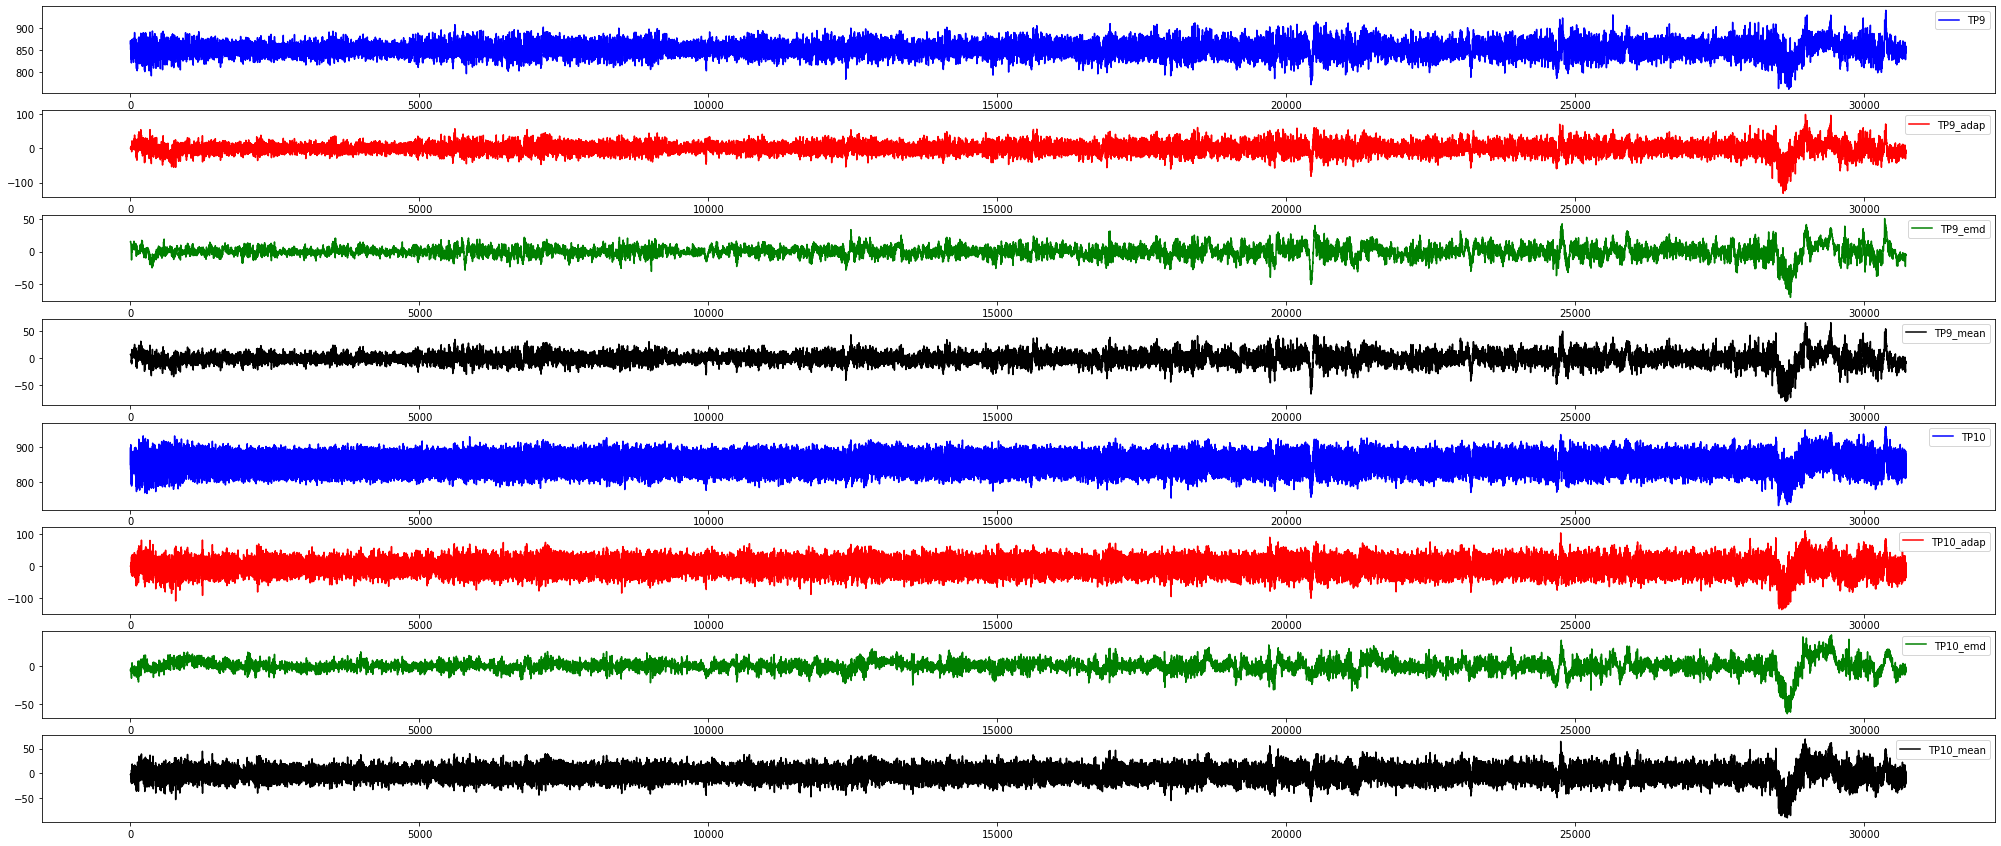

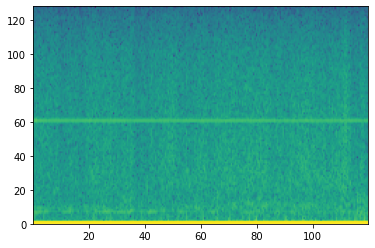

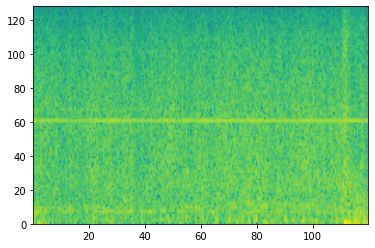

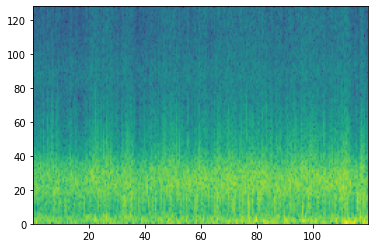

In [48]:
filtering = filters()
eegChan = MT12[:,[0,3]]
eoGChan = MT12[:,[1,2]]
adapMT12 = filtering.adaptive(eegChan,eoGChan)
adapMT12 = np.concatenate((adapMT12,adapMT12),axis=1)

def EMD(data,template_1,template_2):
    imf_chans = emd.sift.sift(data)
    corr = []
    for i in range(imf_chans.shape[1]):
        corr.append(np.corrcoef(imf_chans[:,i],template_1)[0,1])
    corr = np.array(corr)
    # extract indices of negative correlation
    pos_corr = np.where(corr > 0)[0]
    cleanIMFS = np.delete(imf_chans,pos_corr,axis=1)
    regen_signal_1 = np.sum(cleanIMFS,axis=1)

    template_2 = MT12[:,2]
    imf_chans = emd.sift.sift(regen_signal_1)
    corr = []
    for i in range(imf_chans.shape[1]):
        corr.append(np.corrcoef(imf_chans[:,i],template_2)[0,1])
    corr = np.array(corr)
    # extract indices of negative correlation
    pos_corr = np.where(corr > 0)[0]
    cleanIMFS = np.delete(imf_chans,pos_corr,axis=1)
    regen_signal_2 = np.sum(cleanIMFS,axis=1)
    return regen_signal_2

emd_tp9 = EMD(MT12[:,0],MT12[:,1],MT12[:,2])
emd_tp10 = EMD(MT12[:,3],MT12[:,1],MT12[:,2])

# mean of emd and adaptive
mean_tp9 = np.mean(np.vstack((adapMT12[:,0],emd_tp9)),axis=0)
mean_tp10 = np.mean(np.vstack((adapMT12[:,3],emd_tp10)),axis=0)

fig,axis = plt.subplots(8,1,figsize=(35,15))
axis[0].plot(MT12[:,0],label='TP9',color='blue')
axis[1].plot(adapMT12[:,0],label='TP9_adap',color='red')
axis[2].plot(emd_tp9,label='TP9_emd',color='green')
axis[3].plot(mean_tp9,label='TP9_mean',color='black')
axis[4].plot(MT12[:,3],label='TP10',color='blue')
axis[5].plot(adapMT12[:,1],label='TP10_adap',color='red')
axis[6].plot(emd_tp10,label='TP10_emd',color='green')
axis[7].plot(mean_tp10,label='TP10_mean',color='black')
axis[0].legend()
axis[1].legend()
axis[2].legend()
axis[3].legend()
axis[4].legend()
axis[5].legend()
axis[6].legend()
axis[7].legend()
plt.show()


fig, ax1 = plt.subplots()
ax1.specgram(MT12[:,0], Fs = 256) 
plt.show()
fig, ax1 = plt.subplots()
ax1.specgram(adapMT12[:,0], Fs = 256) 
plt.show()
fig, ax1 = plt.subplots()
ax1.specgram(emd_tp9, Fs = 256) 
plt.show()


Adaptive filter Test

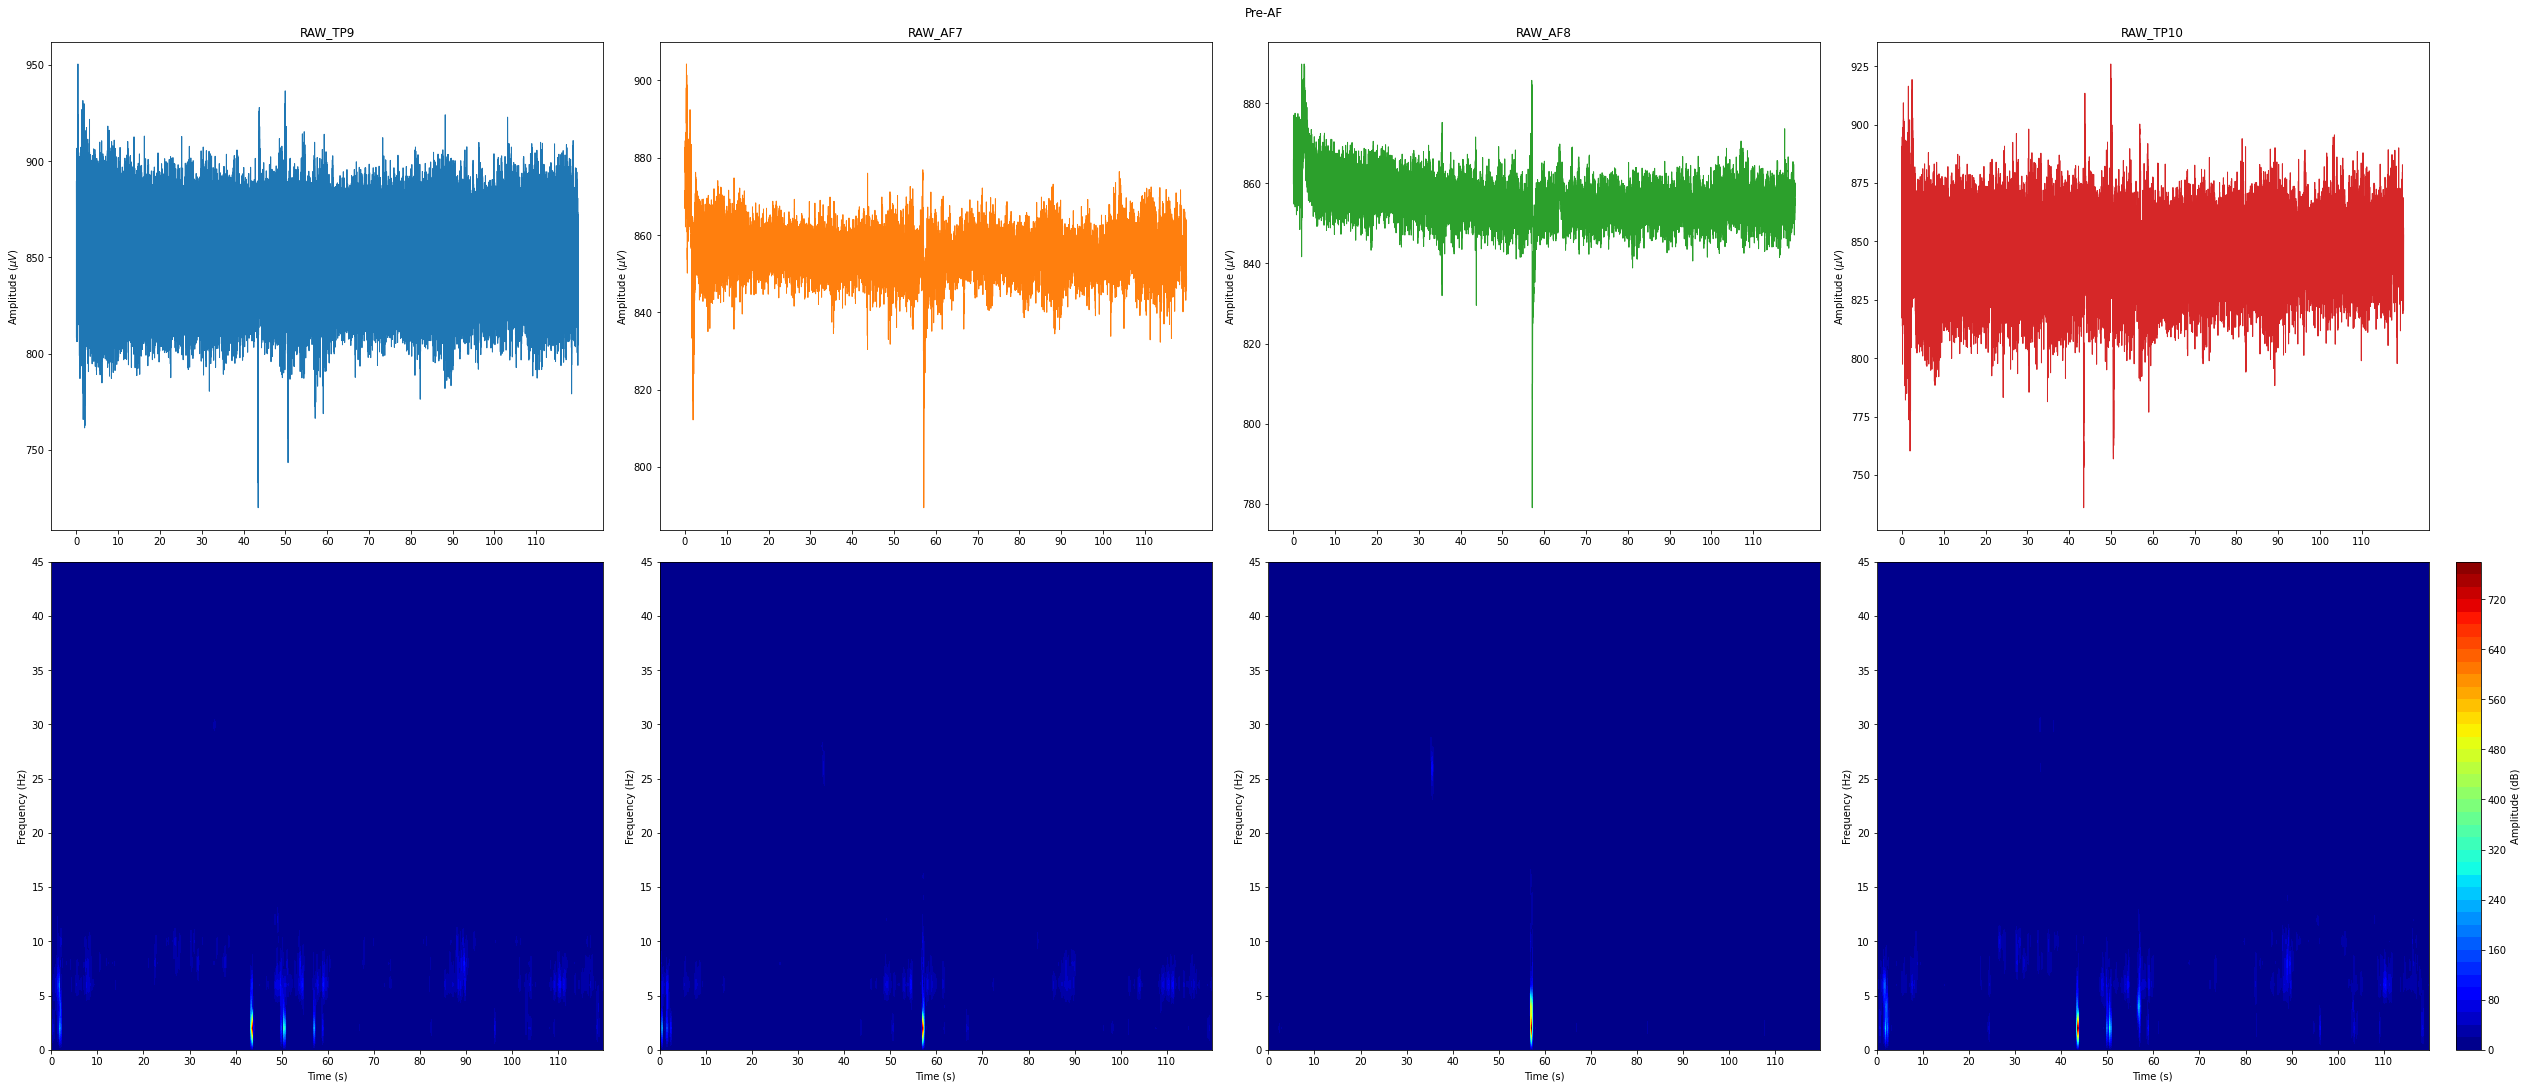

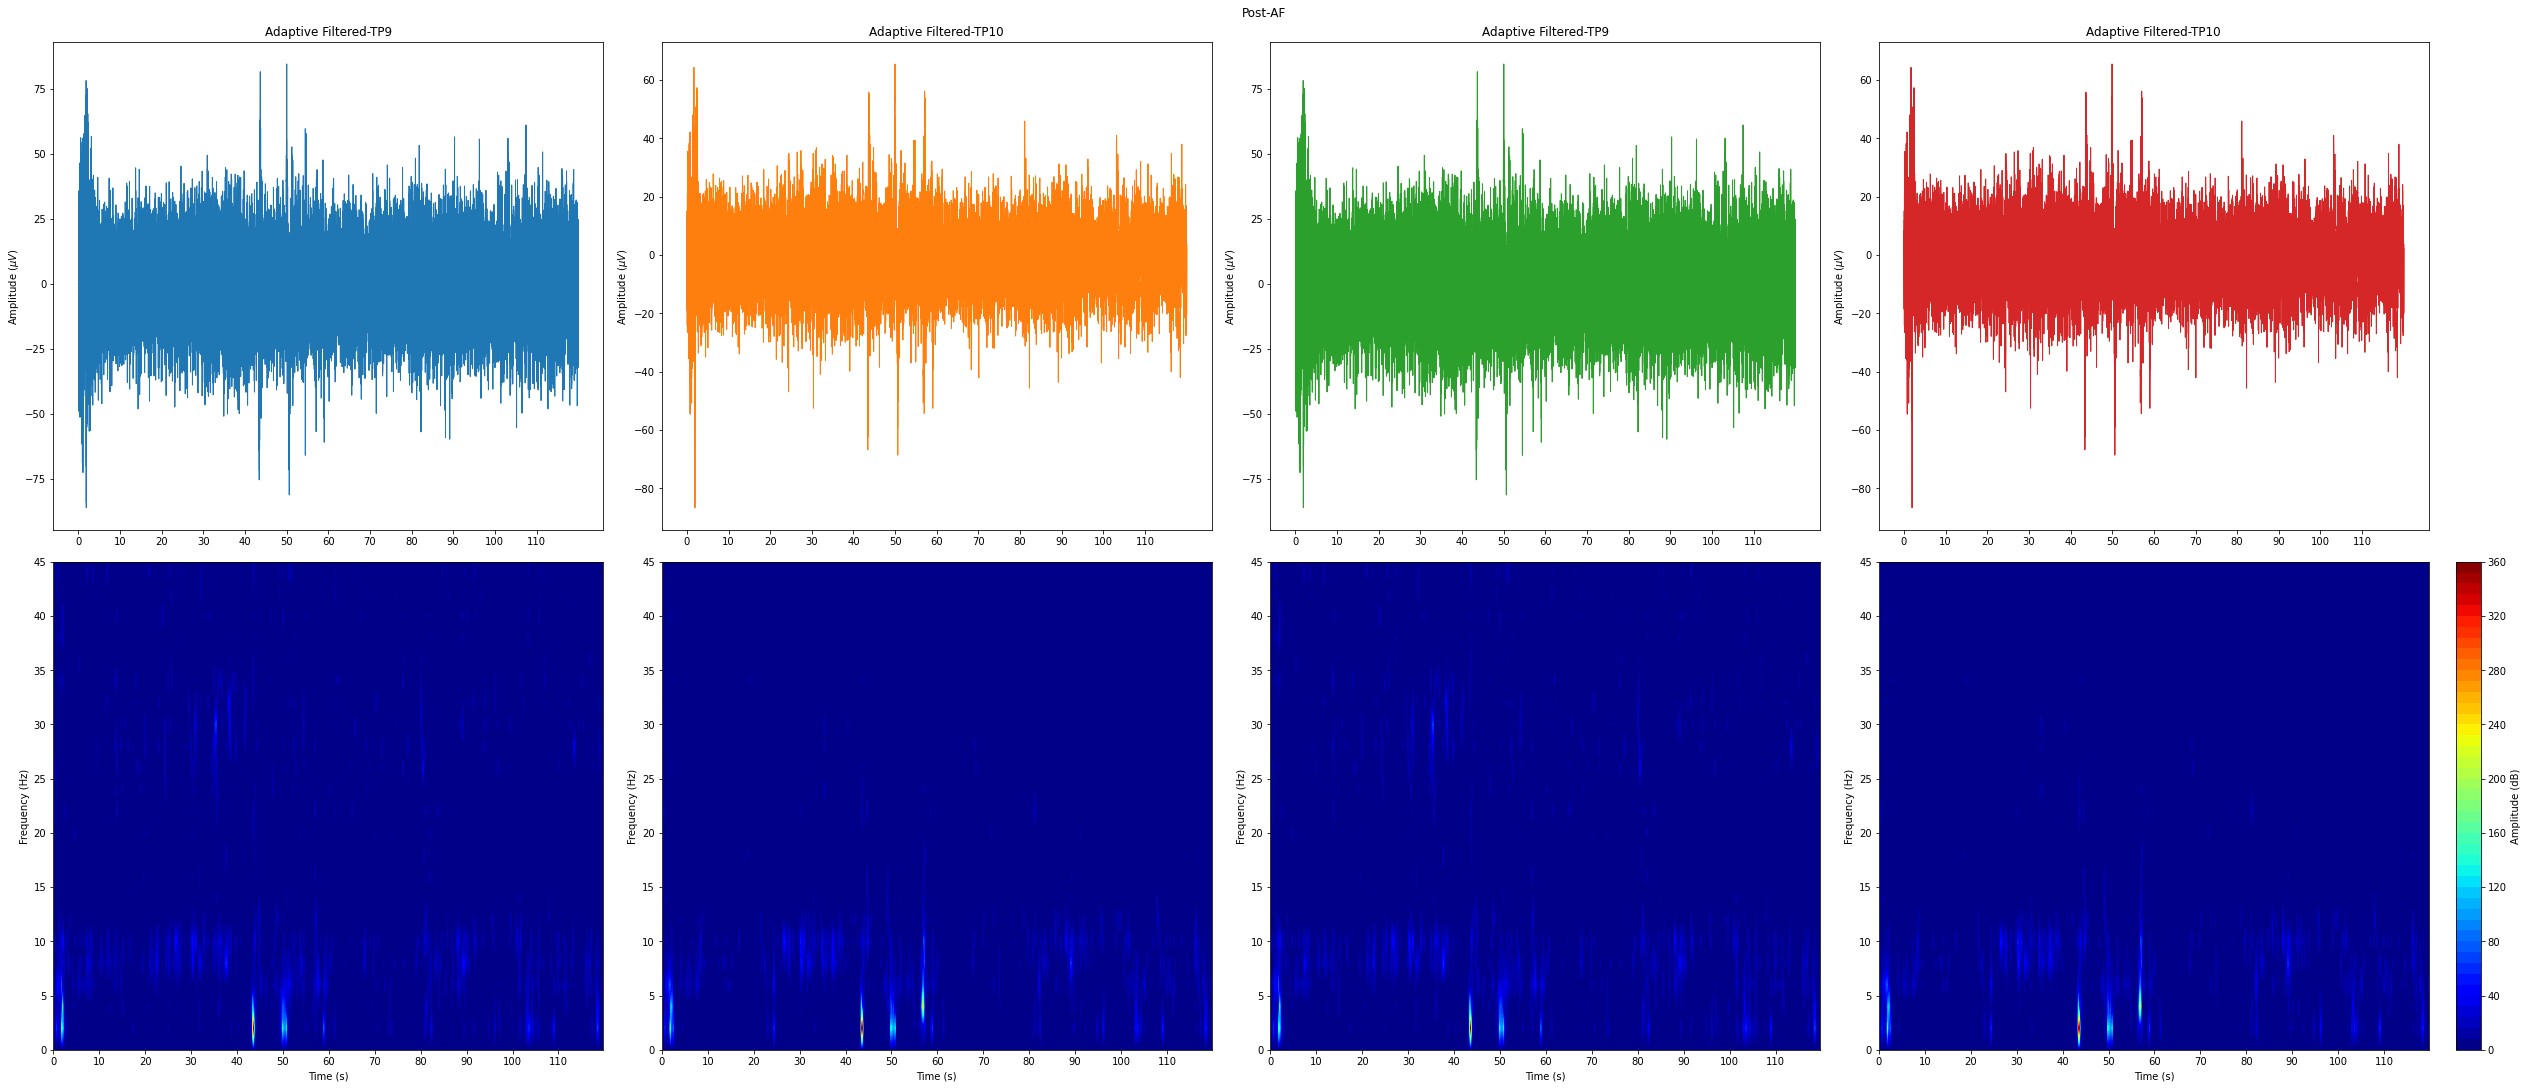

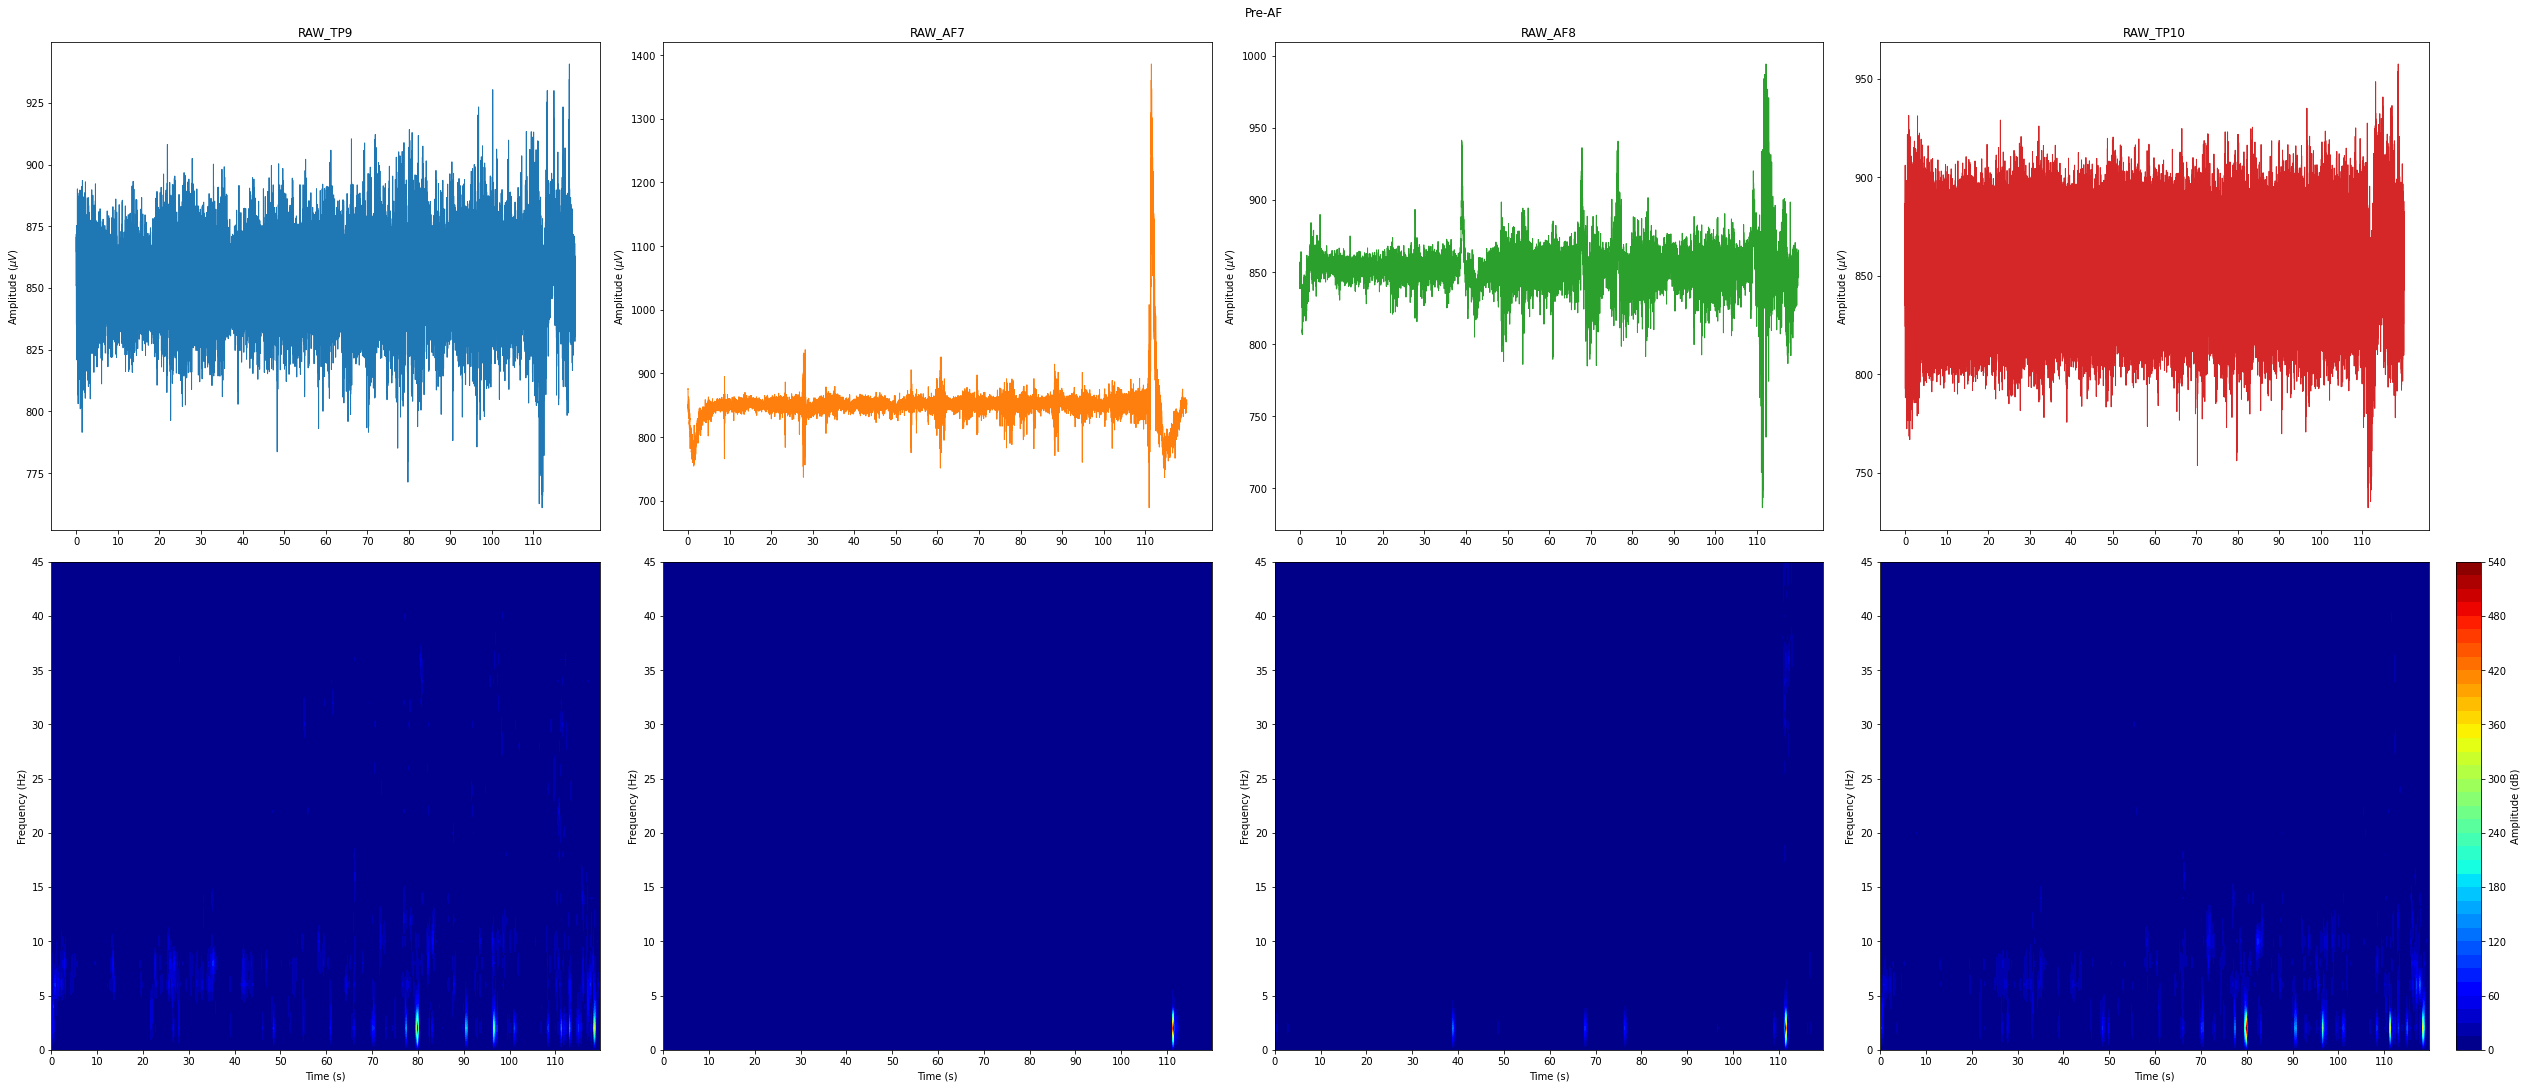

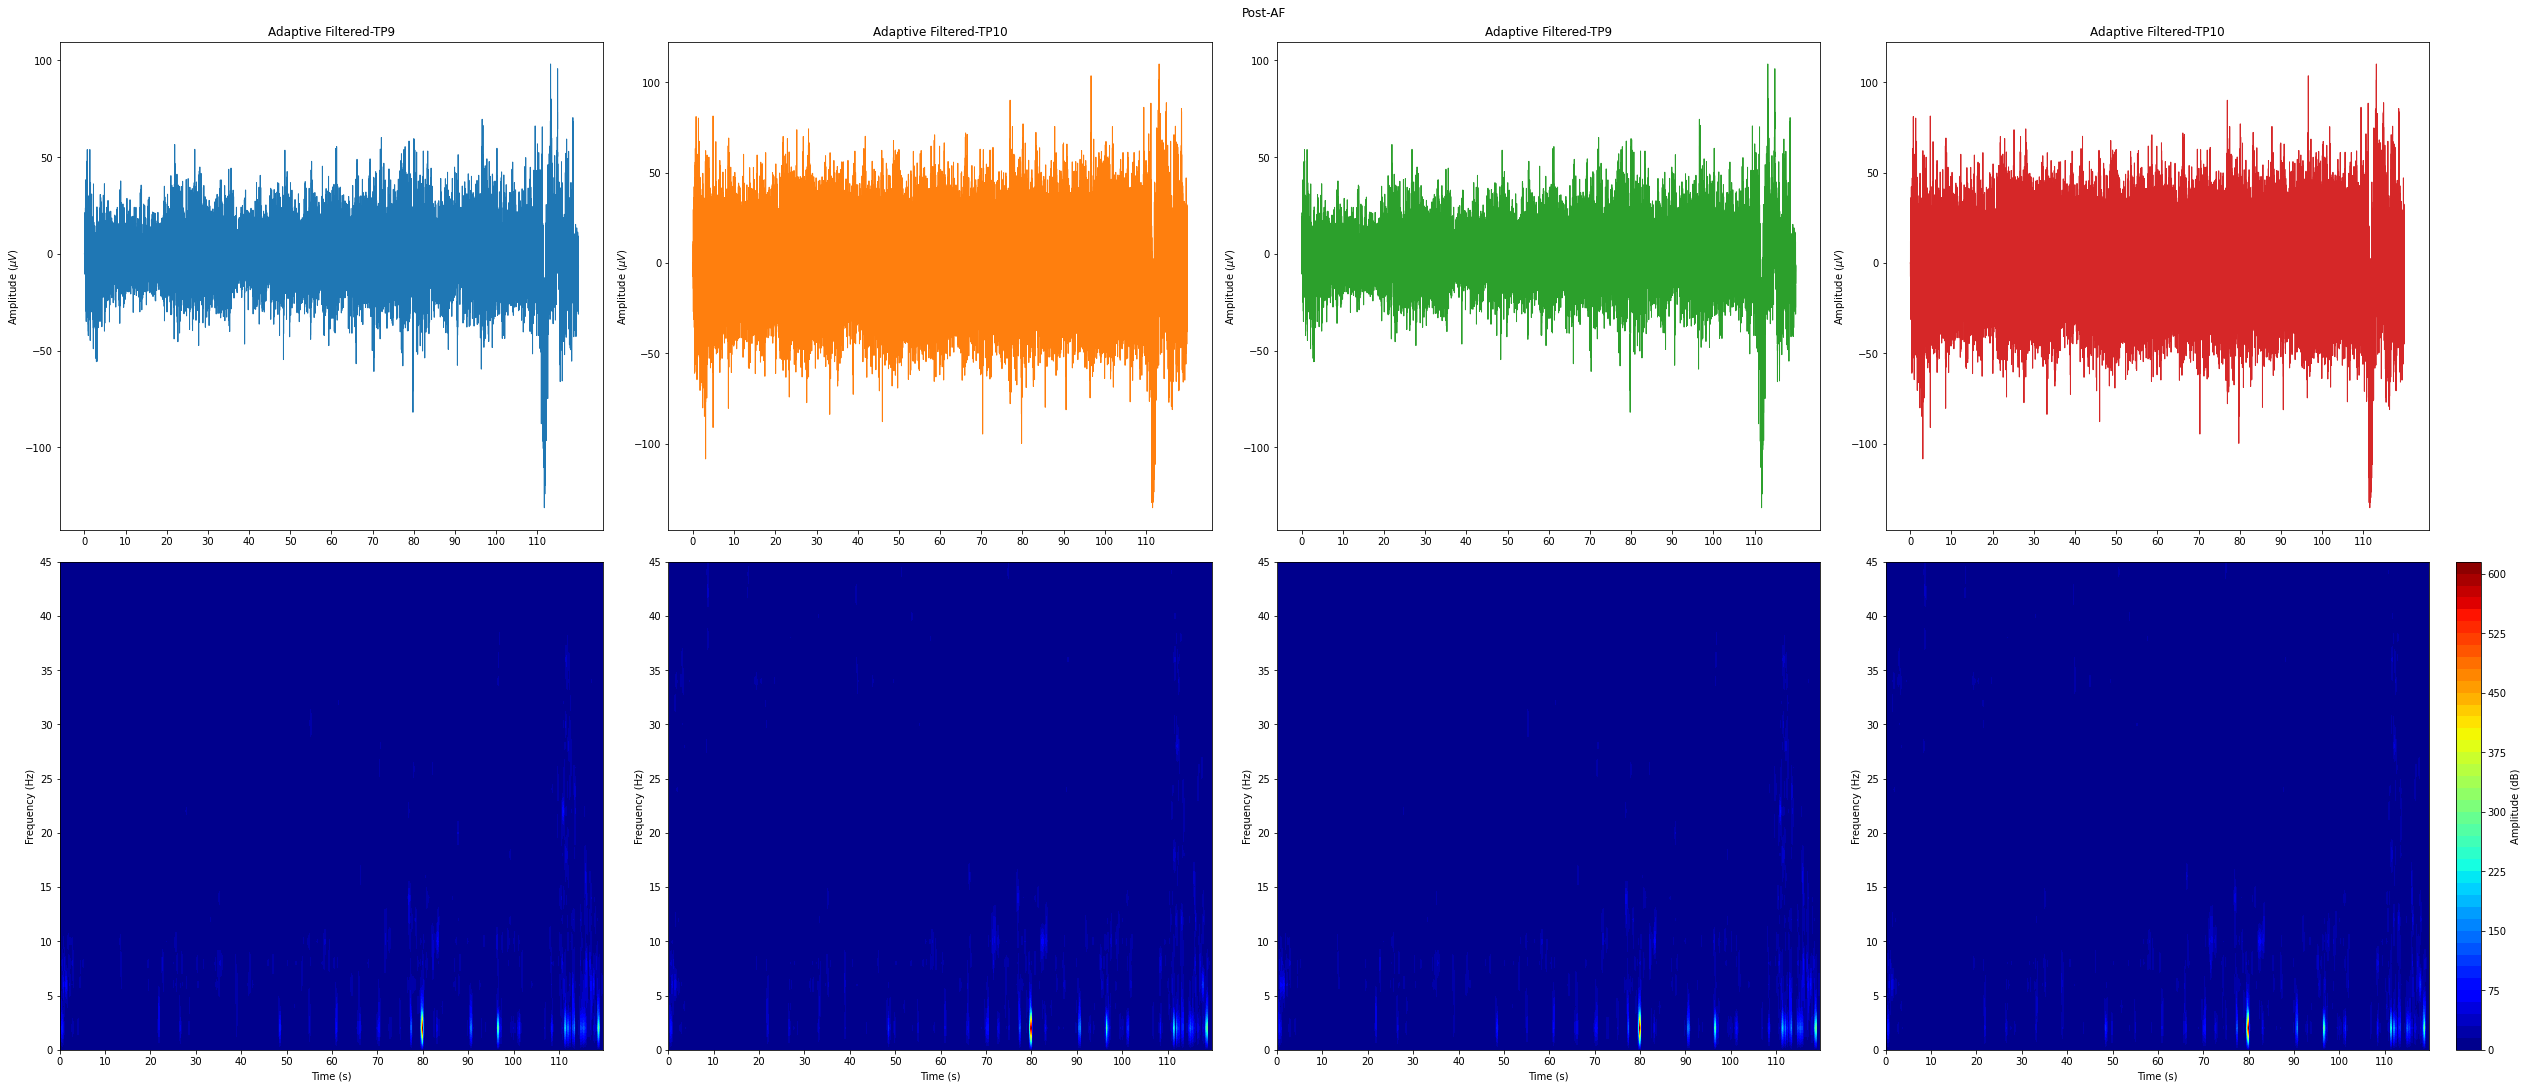

In [39]:
filtering = filters()
eegChan = MT11[:,[0,3]]
eoGChan = MT11[:,[1,2]]
adapMT11 = filtering.adaptive(eegChan,eoGChan)
adapMT11 = np.concatenate((adapMT11,adapMT11),axis=1)

plots(data=MT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
          title='Pre-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)
plots(data=adapMT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['Adaptive Filtered-TP9','Adaptive Filtered-TP10','Adaptive Filtered-TP9','Adaptive Filtered-TP10'],
          title='Post-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

filtering = filters()
eegChan = MT12[:,[0,3]]
eoGChan = MT12[:,[1,2]]
adapMT12 = filtering.adaptive(eegChan,eoGChan)
adapMT12 = np.concatenate((adapMT12,adapMT12),axis=1)
plots(data=MT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='Pre-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

plots(data=adapMT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['Adaptive Filtered-TP9','Adaptive Filtered-TP10','Adaptive Filtered-TP9','Adaptive Filtered-TP10'],
          title='Post-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

In [40]:
m1_delta = avgBandPower(n_eegM1,256,0.5,4)
m2_delta = avgBandPower(n_eegM2,256,0.5,4)
m1_theta = avgBandPower(n_eegM1,256,4,8)
m2_theta = avgBandPower(n_eegM2,256,4,8)
m1_alpha = avgBandPower(n_eegM1,256,8,12)
m2_alpha = avgBandPower(n_eegM2,256,8,12)
m1_beta = avgBandPower(n_eegM1,256,12,30)
m2_beta = avgBandPower(n_eegM2,256,12,30)
m1_gamma = avgBandPower(n_eegM1,256,30,50)
m2_gamma = avgBandPower(n_eegM2,256,30,50)
print("Delta:",m1_delta,m2_delta)
print("Theta:",m1_theta,m2_theta)
print("Alpha:",m1_alpha,m2_alpha)
print("Beta:",m1_beta,m2_beta)
print("Gamma:",m1_gamma,m2_gamma)

NameError: name 'n_eegM1' is not defined

In [ ]:
import emd
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score


chanInput = eeg[:,0]
imf_chans = emd.sift.sift(chanInput)
def autocorrelation(data):
    x = np.array(data) 
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr
acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
acfs_chanInput = autocorrelation(chanInput)
def mutual_information(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
miNorm = mi / np.amax(mi)
if np.amax(miNorm)-np.amin(miNorm) < 0.8:
    theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
    idxs = np.where(miNorm > theta)[0]
    cleanIMF = imf_chans[:,idxs]
    sig = np.sum(cleanIMF,axis=1)


def EMDMI(input):
    def params(chanInput):
        imf_chans = emd.sift.sift(chanInput)
        def autocorrelation(data):
            x = np.array(data) 
            mean = np.mean(data)
            var = np.var(data)
            ndata = data - mean
            acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
            acorr = acorr / var / len(ndata)
            return acorr
        acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
        acfs_chanInput = autocorrelation(chanInput)
        def mutual_information(x, y, bins):
            c_xy = np.histogram2d(x, y, bins)[0]
            mi = mutual_info_score(None, None, contingency=c_xy)
            return mi
        mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
        miNorm = mi / np.amax(mi)
        if np.amax(miNorm)-np.amin(miNorm) < 0.8:
            print("Denoised!")
            theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
            idxs = np.where(miNorm < theta)[0]
            cleanIMF = imf_chans[:,idxs]
            sig = np.sum(cleanIMF,axis=1)
        if np.amax(miNorm)-np.amin(miNorm) > 0.8:
            print("Not Denoised!")
            sig = np.sum(imf_chans,axis=1)
        return sig
    output = []
    for i in range(len(input.T)):
        output.append(params(input[:,i]))
    output = np.asarray(output).T
    return output